# Mine Information from Text 

- Knowledge graphs are one of the most fascinating concepts in data science
- Learn how to build a knowledge graph using text from Wikipedia pages
- We will be working hands-on in Python to build our knowledge graph using the popular spaCy library

Adapted the following [AnalyticsVidhya Post](https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/)

## Entity Extraction

The extraction of a single word entity from a sentence is not a tough task. We can easily do this with the help of parts of speech (POS) tags. The nouns and the proper nouns would be our entities.

However, when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence. 

Let’s get the dependency tags for one of the shortlisted sentences, using the spaCy library:

In [1]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

The ... det
22-year ... amod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


The subject (_nsubj_) in this sentence as per the dependency parser is “old”. That is not the desired entity. We wanted to extract “22-year-old” instead.

The dependency tag of “22-year” is _amod_ which means it is a modifier of “old”. Hence, we should define a rule to extract such entities.

> The rule can be something like this — __extract the subject/object along with its modifiers and also extract the punctuation marks between them__.

But then look at the object (_dobj_) in the sentence. It is just “tournament” instead of “ATP Challenger tournament”. Here, we don’t have the modifiers but compound words.

Compound words are those words that collectively form a new term with a different meaning. Therefore, we can update the above rule to ⁠— __extract the subject/object along with its modifiers, compound words and also extract the punctuation marks between them__.

In short, we will use dependency parsing to extract entities.

## Extract Relations

Entity extraction is half the job done. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

Let’s go back to the example in the last section. We shortlisted a couple of sentences to build a knowledge graph:

![](https://i0.wp.com/s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/10/info_extract.png?resize=1079%2C225&ssl=1)

Both sentences have the same relation – “won”. Let’s see how these relations can be extracted. We will again use dependency parsing:

In [2]:
doc = nlp("Nagal won the first set.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


To extract the relation, we have to find the ROOT of the sentence (which is also the verb of the sentence). Hence, the relation extracted from this sentence would be “won”.

Finally, the knowledge graph from these two sentences will be like this:
![](https://i2.wp.com/s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/10/sample_KG.png?resize=383%2C389&ssl=1)

## Build a Knowledge Graph from Text Data
Time to get our hands on some code! Let’s fire up our Jupyter Notebooks (or whatever IDE you prefer).

We will build a knowledge graph from scratch by using the text from a set of movies and films related to Wikipedia articles. I have already extracted around 4,300 sentences from over 500 Wikipedia articles. Each of these sentences contains exactly two entities – one subject and one object. You can download these sentences from [here](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/10/wiki_sentences_v2.csv).

I suggest using Google Colab for this implementation to speed up the computation time.

### Import Libraries

In [3]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

### Read Data
Read the CSV file containing the Wikipedia sentences:

In [7]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

Let’s inspect a few sample sentences:

In [8]:
candidate_sentences['sentence'].sample(5)

1294                                                       the french film à nous la liberté was voted the film più divertente .
3778                                             many black and white movies have been colorized recently using digital tinting.
286     the second film was also the first disney theatrical feature film with the computer-generated walt disney pictures logo.
3344                                                                           a very popular form of such art was pardeh khani.
1001                                                      a few silent charlie chan films, now lost, were produced in the 1920s.
Name: sentence, dtype: object

Let’s check the subject and object of one of these sentences. Ideally, there should be one subject and one object in the sentence:

In [9]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
    print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


Perfect! There is only one subject (‘process’) and only one object (‘standard’). You can check for other sentences in a similar manner.

## Entity Pairs Extraction

> To build a knowledge graph, the most important things are the nodes and the edges between them.

These nodes are going to be the entities that are present in the Wikipedia sentences. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.

__The main idea is to go through a sentence and extract the subject and the object as and when they are encountered__. However, there are a few challenges ⁠— an entity can span across multiple words, eg., “red wine”, and the dependency parsers tag only the individual words as subjects or objects.

So, I have created a function below to extract the subject and the object (entities) from a sentence while also overcoming the challenges mentioned above. I have partitioned the code into multiple chunks for your convenience:

In [10]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                prefix = prv_tok_text + " "+ tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                modifier = prv_tok_text + " "+ tok.text

        ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

        ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text

        ## chunk 5  
        # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

Let me explain the code chunks in the function above:

#### Chunk 1

I have defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

#### Chunk 2

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

#### Chunk 3

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

#### Chunk 4

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

#### Chunk 5

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

Let’s test this function on a sentence:

In [11]:
get_entities("the film had 200 patents")

['film', '200  patents']

In the above sentence, ‘film’ is the subject and ‘200 patents’ is the object.

Now we can use this function to extract these entity pairs for all the sentences in our data:

In [12]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:27<00:00, 158.28it/s]


The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them:

In [13]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global m global global', 'sales rights sales rights rights'],
 ['robbie robertson robbie robertson robertson', 'soundtrack'],
 ['it', 'music tracks music tracks tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'quicksilver  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt kota eberhardt eberhardt', 'selene  gallio'],
 ['singer', 'sequel']]

## Relation / Predicate Extraction
This is going to be a very interesting aspect of this article. __Our hypothesis is that the predicate is actually the main verb in a sentence__.

For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the predicate for the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching:

In [14]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word.

Let me show you a glimpse of this function:

In [20]:
get_relation("John completed the task")

'completed'

Similarly, let’s get the relations from all the Wikipedia sentences:

In [16]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:28<00:00, 152.89it/s]


Let’s take a look at the most frequent relations or predicates that we have just extracted:

In [17]:
pd.Series(relations).value_counts()[:50]

is               357
was              288
released on       80
are               72
were              69
include           63
's                39
released          37
became            31
become            28
composed by       28
have              27
has               27
released in       23
included          20
been              19
considered        18
made              18
be                17
had               17
called            17
used              17
produced          16
received          15
scheduled         15
directed by       14
hired             14
set               14
went              13
introduced in     13
sold              12
produced by       12
wanted            12
written by        12
wrote             11
won               11
began in          10
includes          10
stars             10
began             10
gave              10
cast as           10
directed           9
reported           9
opened             9
produced in        9
shot in            9
revealed     

It turns out that relations like “A is B” and “A was B” are the most common relations. However, there are quite a few relations that are more associated with the overall theme – “the ecosystem around movies”. Some of the examples are “composed by”, “released in”, “produced”, “written by” and a few more.

## Build a Knowledge Graph
We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [21]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

__It is going to be a directed graph__. In other words, the relation between any connected node pair is not two-way, it is only from one node to another. For example, “John __eats__ pasta”:

In [22]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Let’s plot the network:

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


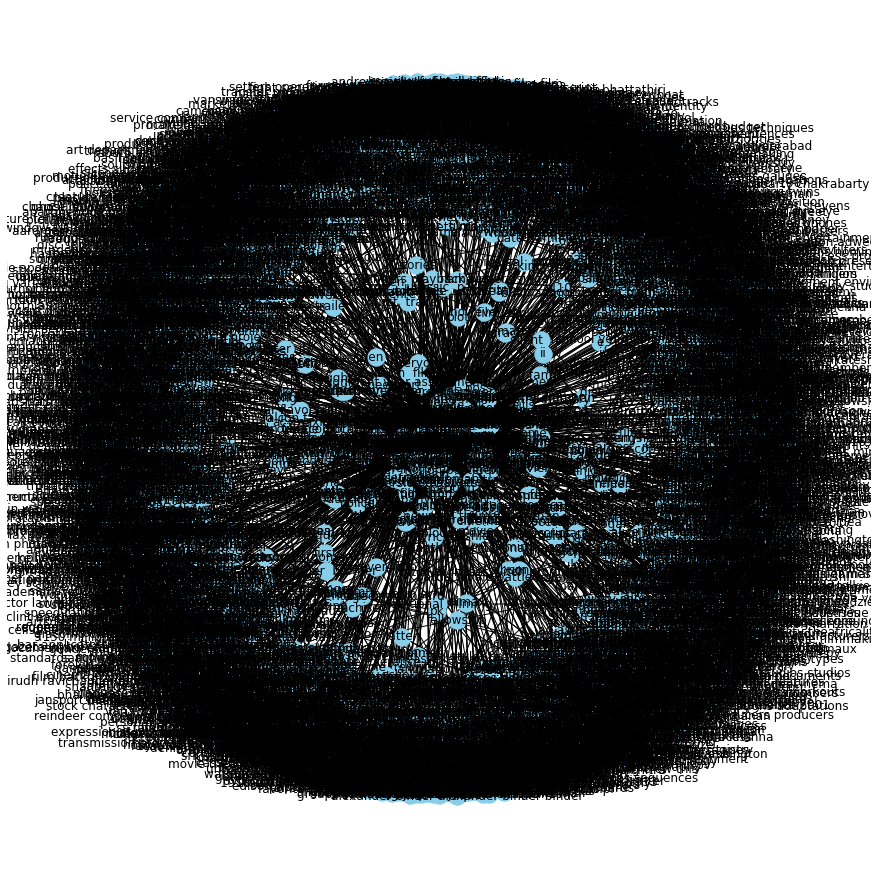

In [23]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)

Well, this is not exactly what we were hoping for (still looks quite a sight though!).

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation “composed by”:

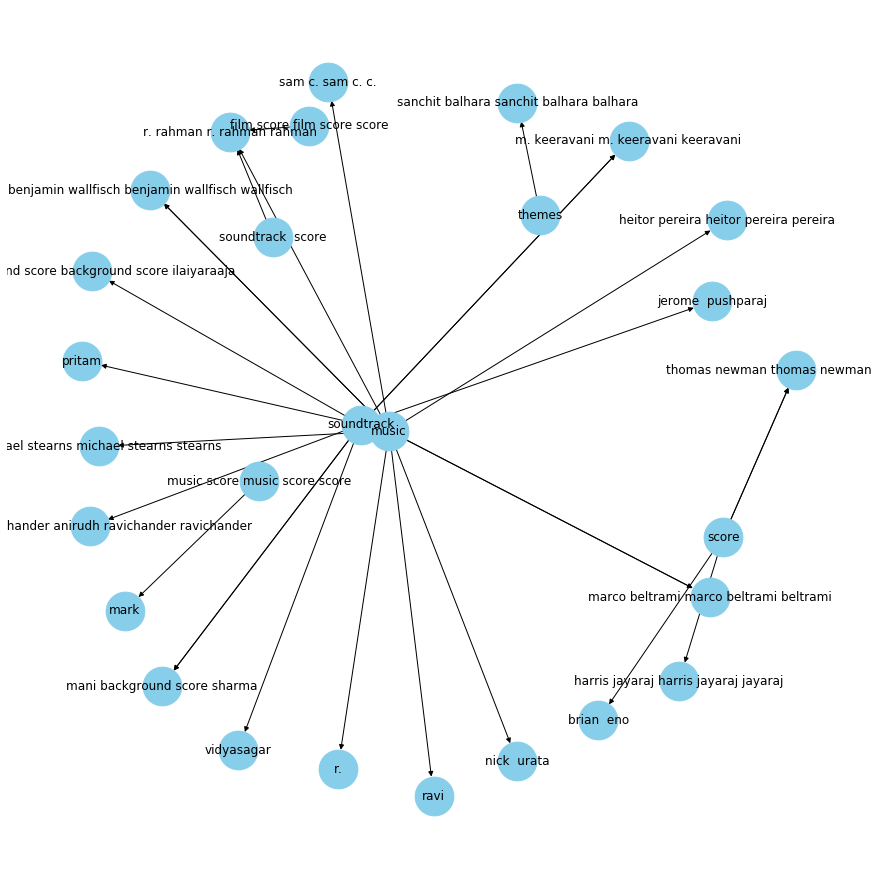

In [24]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph. Here the arrows point towards the composers. For instance, A.R. Rahman, who is a renowned music composer, has entities like “soundtrack score”, “film score”, and “music” connected to him in the graph above.

Let’s check out a few more relations.

Since writing is an important role in any movie, I would like to visualize the graph for the “written by” relation:

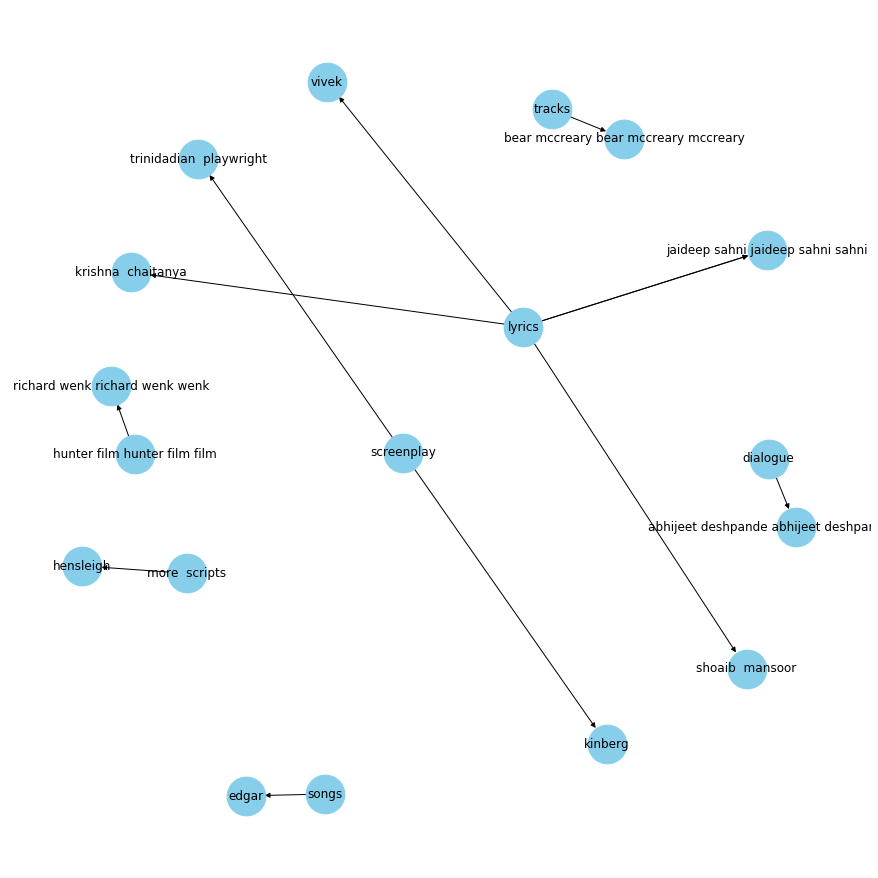

In [25]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Awesome! This knowledge graph is giving us some extraordinary information. Guys like Javed Akhtar, Krishna Chaitanya, and Jaideep Sahni are all famous lyricists and this graph beautifully captures this relationship.

Let’s see the knowledge graph of another important predicate, i.e., the “released in”:

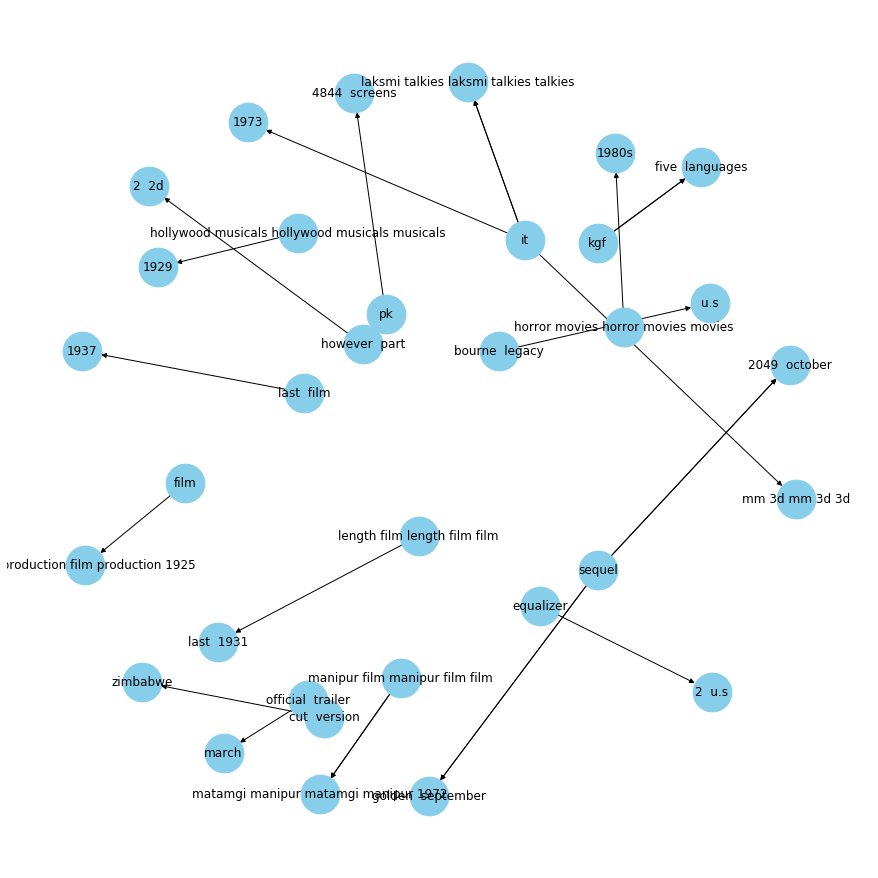

In [26]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()